In [1]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [2]:
# Verificar se a GPU está disponível
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")


GPU is not available


In [3]:
# Diretório onde estão armazenadas as imagens
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'


In [4]:
# Função para carregar e redimensionar as imagens
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  
        return np.array(image) / 255.0  
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [5]:
# Carregar IDs do grupo de treinamento
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\higher_resolution_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [6]:
# Carregar IDs do grupo de validação
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\higher_resolution_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [10]:
%%capture
# Listas para armazenar caminhos de imagem e rótulos correspondentes
train_data = []
val_data = []

# Iterar sobre todos os arquivos no diretório
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [11]:
# Verificar o número de imagens carregadas
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 5240
Número de imagens de validação carregadas: 1746


In [12]:
# Separar as imagens e os rótulos (labels)
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

In [13]:
val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [14]:
# Carregar as imagens
train_images = [load_image(image_path, target_size=(112, 112)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(112, 112)) for image_path in val_images]

In [15]:
# Verificar se alguma imagem falhou ao carregar
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [16]:
# Converter os rótulos em formato adequado (numérico)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [17]:
# One-hot encoding dos rótulos
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

C:\Users\bruna\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
# Carregar o modelo base ResNet50 com pesos pré-treinados da ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [19]:
# Congelar as camadas da ResNet50 para treinar apenas as camadas personalizadas
base_model.trainable = False

In [20]:
# Adicionar novas camadas no topo do modelo base
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [21]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
# Fine-tuning 
# Descongelar as últimas camadas da ResNet50 para fazer fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [23]:
# Recompilar o modelo 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [24]:
# Continuar o treinamento com fine-tuning
history_finetune = model.fit(
    np.array(train_images), 
    train_labels_one_hot, 
    epochs=10, 
    batch_size=32, 
    validation_data=(np.array(val_images), val_labels_one_hot)
)

Epoch 1/10
164/164 [==============================] - 227s 1s/step - loss: 1.5551 - accuracy: 0.3153 - val_loss: 1.5835 - val_accuracy: 0.2205
Epoch 2/10
164/164 [==============================] - 221s 1s/step - loss: 1.4508 - accuracy: 0.3613 - val_loss: 1.4716 - val_accuracy: 0.3362
Epoch 3/10
164/164 [==============================] - 221s 1s/step - loss: 1.4073 - accuracy: 0.3979 - val_loss: 1.4184 - val_accuracy: 0.3574
Epoch 4/10
164/164 [==============================] - 218s 1s/step - loss: 1.3664 - accuracy: 0.4137 - val_loss: 1.3262 - val_accuracy: 0.4422
Epoch 5/10
164/164 [==============================] - 223s 1s/step - loss: 1.3312 - accuracy: 0.4326 - val_loss: 1.3214 - val_accuracy: 0.4364
Epoch 6/10
164/164 [==============================] - 205s 1s/step - loss: 1.3020 - accuracy: 0.4468 - val_loss: 1.2504 - val_accuracy: 0.4966
Epoch 7/10
164/164 [==============================] - 199s 1s/step - loss: 1.2636 - accuracy: 0.4668 - val_loss: 1.2156 - val_accuracy: 0.4897

In [25]:
model.save('trained_model.resnet_higher_resolution')

INFO:tensorflow:Assets written to: trained_model.resnet_higher_resolution\assets


INFO:tensorflow:Assets written to: trained_model.resnet_higher_resolution\assets


In [26]:
# Avaliar no conjunto de validação
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

55/55 [==============================] - 37s 666ms/step - loss: 1.1988 - accuracy: 0.4880
Loss no conjunto de validação: 1.1987966299057007
Accuracy no conjunto de validação: 0.4879724979400635


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Obter previsões do modelo
val_predictions = model.predict(np.array(val_images))

# Converter previsões one-hot encoded para rótulos
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Relatório de classificação
target_names = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4']
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

55/55 [==============================] - 36s 632ms/step
Matriz de Confusão:
[[ 10   5  58  69  37]
 [ 10  87  42 115 114]
 [ 12   1 277 108  34]
 [  8   7  97 295  64]
 [  2   6  29  76 183]]
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.24      0.06      0.09       179
    Classe 1       0.82      0.24      0.37       368
    Classe 2       0.55      0.64      0.59       432
    Classe 3       0.44      0.63      0.52       471
    Classe 4       0.42      0.62      0.50       296

    accuracy                           0.49      1746
   macro avg       0.50      0.44      0.41      1746
weighted avg       0.53      0.49      0.46      1746



In [28]:
# Salvar a matriz de confusão e o relatório de classificação
np.save('confusion_matrix.npy', conf_matrix)

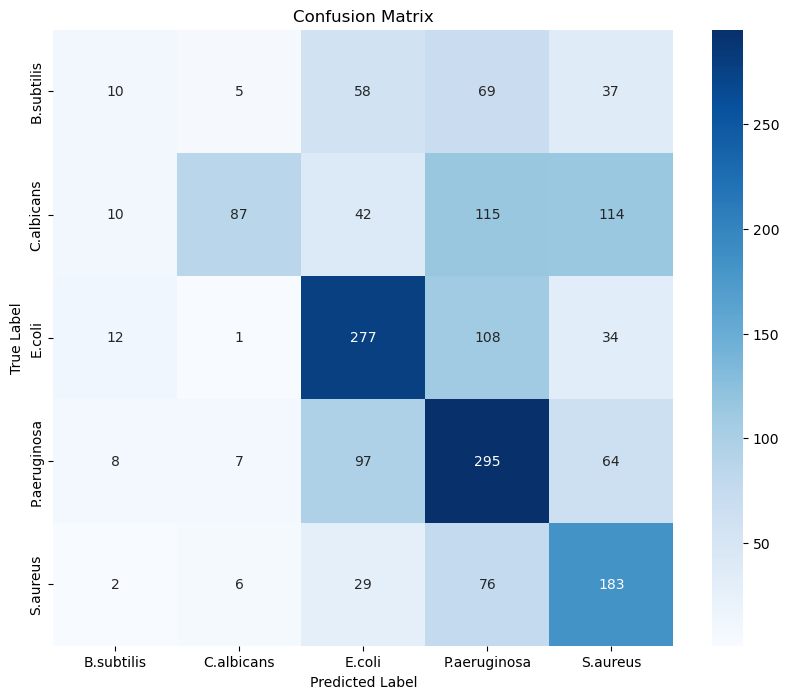

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()